In [2]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:    
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

## Loading The Dataset

In [2]:
!python --version

Python 3.11.11


In [3]:
import torch
torch.__version__

'2.6.0+cu124'

In [4]:
url = '/kaggle/input/celeba-dataset/img_align_celeba/img_align_celeba'

#### Creating a function to load the data in image format

In [5]:
import os
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image


class CelebADataset(Dataset):
    def __init__ ( self, root_dir , transform = None ) :
        '''
        Args: 
            root_dir (string ) : Directory with all the images
            transform (callable , optional ) : Optional transform to be applied on a sample.
        '''
        self.root_dir = root_dir
        self.transform = transform 

        # Get all the image gile paths form the directory 
        self.image_paths = [os.path.join(root_dir , img ) for img in os.listdir (root_dir ) if img.endswith('.jpg')]
    
    def __len__(self):
        return len(self.image_paths)

    def __getitem__ (self, idx ) :
        # load images
        img_path = self.image_paths[idx]
        image = Image.open (img_path).convert("RGB")

        # Apply the transform if provided 
        if self.transform:
            image = self.transform ( image )

        return image

#### Creating a transformation 

Pre-processing the image:  
1. Resizing and cropping the image to 64 pixels
2. Converting it to a tensor
3. Normalizing values, such that output pixel values are between -1 and 1

Creating a data loader :  
Loads the dataset in a batch size of 128

In [6]:
transform = transforms.Compose([
    transforms.Resize(64), # Resize images to 64*64 
    transforms.CenterCrop(64), # Center crop the image
    transforms.ToTensor() , # Convert image to tensor
    transforms.Normalize( mean = [0.5,0.5,0.5] , std = [0.5,0.5,0.5])
           # this normalizes the pixel values from -1 to 1
])

# Load Celeba dataset from the directory 
dataset = CelebADataset(root_dir=url, transform= transform)

# Creating Dataloader. 
    # because we cannot load the entire image at once to the Computer, 
    # dataloader will device the dataset into images, and load it in batches
dataloader = DataLoader (dataset , batch_size = 128 , shuffle=True)

#Check how many images are loaded 
print("Total number of images loaded : ",  len(dataset))

Total number of images loaded :  202599


## Creating the Generator

In [7]:
## Writing the code for generator 
import torch.nn as nn
import torch.optim as optim 
from torch.utils.data import DataLoader
from torchvision import transforms
import matplotlib.pyplot as plt
import os
from PIL import Image
import torchvision
import numpy as np 


class Generator ( nn.Module ) :
    def __init__( self , z_dim=100 , img_channels=3):
        super (Generator, self).__init__()
        
        # z_dim = random noise, the generator takes input noise, and transforms it into an image. 
        # noise of Normal Distribution 
        
        # increasing the dimension of the vector, because we cant generate an image of 100 values only 
        self.model = nn.Sequential(
            nn.Linear (z_dim , 256 ), # take input of z_dim, and give 1 d vector of 256 values
            nn.ReLU (True), # activation Function 
            nn.Linear (256, 512),  # input Vector of 256 values, output : vector of 512 values
            nn.ReLU(True), 
            nn.Linear(512, 1024),
            nn.ReLU ( True ),
            nn.Linear ( 1024, img_channels * 64 * 64) , # Now converting 1024 to an image of dimensions 64* 64 
            nn.Tanh() # using tanh because it converts pixel values in between -1 and 1, 
            # which we already transformed our image into 
            
        )

    def forward (self, z) :
        img = self.model(z)
        img = img.view( img .size(0) , 3 , 64, 64) # Reshaping the image format
        return img
    

## Creating the Discriminator 

In [8]:
class Discriminator ( nn.Module) :
    def __init__ ( self, img_channel=3 ):
        super (Discriminator , self ) .__init__()

        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear( img_channel*64 * 64 , 1024),
            nn.LeakyReLU (0.2 , inplace=True),
            nn.Linear(1024 , 512),
            nn.LeakyReLU (0.2 , inplace=True),
            nn.Linear( 512 , 256),
            nn.LeakyReLU (0.2 , inplace=True),
            nn.Linear( 256 ,1),
            nn.Sigmoid()
        )

    def forward ( self , img ):
        return self.model(img)

## Training the model

#### Loss funcation and optimizers

In [9]:

# Loss function and optimizers
adversarial_loss = nn.BCELoss()
generator = Generator(z_dim=100)
discriminator = Discriminator()
optimizer_G = optim.Adam(generator.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizer_D = optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.5, 0.999))

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
generator = generator.to(device)
discriminator = discriminator.to(device)


#### Training


In [10]:
def train(generator, discriminator, dataloader, epochs=5):
    for epoch in range(epochs):
        for i, imgs in enumerate(dataloader):
            real_imgs = imgs.to(device)
            batch_size = real_imgs.size(0)
            valid = torch.ones(batch_size, 1).to(device) # labeling real images as 1
            fake = torch.zeros(batch_size, 1).to(device) # labeling fake images as 0 

            # Train Discriminator
            optimizer_D.zero_grad()
            real_loss = adversarial_loss(discriminator(real_imgs), valid)
            fake_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, 100).to(device)).detach()), fake)
            d_loss = (real_loss + fake_loss) / 2
            d_loss.backward()
            optimizer_D.step()

            # Train Generator
            optimizer_G.zero_grad()
            g_loss = adversarial_loss(discriminator(generator(torch.randn(batch_size, 100).to(device))), valid)
            g_loss.backward()
            optimizer_G.step()

            if i % 50 == 0:
                print(f"[Epoch {epoch}/{epochs}] [Batch {i}/{len(dataloader)}] [D loss: {d_loss.item()}] [G loss: {g_loss.item()}]")

        # Optionally, save generated images at each epoch
        save_generated_images(generator, epoch, device)

#### Saving Generated images

In [12]:
def save_generated_images(generator, epoch, device, num_images=16):
    z = torch.randn(num_images, 100).to(device)
    generated_imgs = generator(z).detach().cpu()
    grid = torchvision.utils.make_grid(generated_imgs, nrow=4, normalize=True)
    plt.imshow(np.transpose(grid, (1, 2, 0)))
    plt.title(f"Epoch {epoch}")
    plt.axis('off')
    plt.show()

#### Start Traning 

[Epoch 0/20] [Batch 0/1583] [D loss: 0.6959413290023804] [G loss: 0.7299289703369141]
[Epoch 0/20] [Batch 50/1583] [D loss: 0.30820396542549133] [G loss: 1.0538965463638306]
[Epoch 0/20] [Batch 100/1583] [D loss: 0.10145588219165802] [G loss: 2.453202724456787]
[Epoch 0/20] [Batch 150/1583] [D loss: 0.10291406512260437] [G loss: 2.1940321922302246]
[Epoch 0/20] [Batch 200/1583] [D loss: 0.08333155512809753] [G loss: 3.6446619033813477]
[Epoch 0/20] [Batch 250/1583] [D loss: 0.2657661736011505] [G loss: 2.331082344055176]
[Epoch 0/20] [Batch 300/1583] [D loss: 0.06612840294837952] [G loss: 2.9080803394317627]
[Epoch 0/20] [Batch 350/1583] [D loss: 0.12471969425678253] [G loss: 3.420795202255249]
[Epoch 0/20] [Batch 400/1583] [D loss: 0.014958835206925869] [G loss: 3.105987548828125]
[Epoch 0/20] [Batch 450/1583] [D loss: 0.0341116338968277] [G loss: 4.9041242599487305]
[Epoch 0/20] [Batch 500/1583] [D loss: 0.10232894867658615] [G loss: 2.018078088760376]
[Epoch 0/20] [Batch 550/1583] [

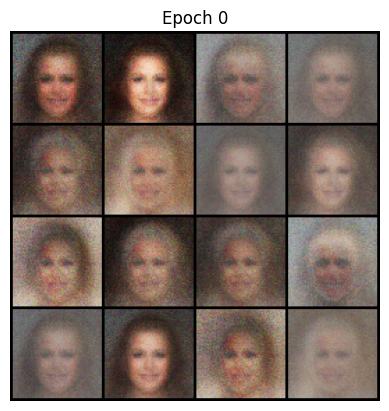

[Epoch 1/20] [Batch 0/1583] [D loss: 0.3113173544406891] [G loss: 3.7811713218688965]
[Epoch 1/20] [Batch 50/1583] [D loss: 0.22522640228271484] [G loss: 2.362151622772217]
[Epoch 1/20] [Batch 100/1583] [D loss: 0.22760048508644104] [G loss: 3.1158056259155273]
[Epoch 1/20] [Batch 150/1583] [D loss: 0.18867215514183044] [G loss: 2.724381923675537]
[Epoch 1/20] [Batch 200/1583] [D loss: 0.26164838671684265] [G loss: 1.9926445484161377]
[Epoch 1/20] [Batch 250/1583] [D loss: 0.3029859662055969] [G loss: 1.8010884523391724]
[Epoch 1/20] [Batch 300/1583] [D loss: 0.2967928946018219] [G loss: 3.1521353721618652]
[Epoch 1/20] [Batch 350/1583] [D loss: 0.23297642171382904] [G loss: 3.103844165802002]
[Epoch 1/20] [Batch 400/1583] [D loss: 0.3582141399383545] [G loss: 2.864825487136841]
[Epoch 1/20] [Batch 450/1583] [D loss: 0.2635515332221985] [G loss: 2.515737533569336]
[Epoch 1/20] [Batch 500/1583] [D loss: 0.23535504937171936] [G loss: 3.0666420459747314]
[Epoch 1/20] [Batch 550/1583] [D l

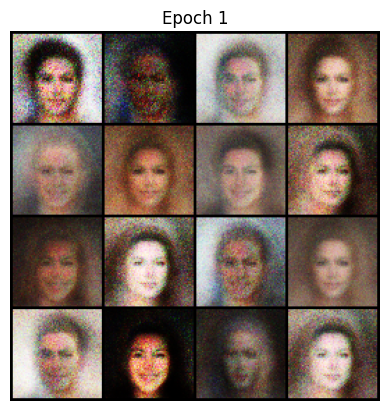

[Epoch 2/20] [Batch 0/1583] [D loss: 0.2907419204711914] [G loss: 2.4036762714385986]
[Epoch 2/20] [Batch 50/1583] [D loss: 0.4632538855075836] [G loss: 1.8996022939682007]
[Epoch 2/20] [Batch 100/1583] [D loss: 0.319330096244812] [G loss: 2.355776786804199]
[Epoch 2/20] [Batch 150/1583] [D loss: 0.3474438786506653] [G loss: 3.518623113632202]
[Epoch 2/20] [Batch 200/1583] [D loss: 0.30417630076408386] [G loss: 2.957610607147217]
[Epoch 2/20] [Batch 250/1583] [D loss: 0.4033513069152832] [G loss: 2.168942928314209]
[Epoch 2/20] [Batch 300/1583] [D loss: 0.395862877368927] [G loss: 1.9292867183685303]
[Epoch 2/20] [Batch 350/1583] [D loss: 0.3329537808895111] [G loss: 3.522123336791992]
[Epoch 2/20] [Batch 400/1583] [D loss: 0.35860365629196167] [G loss: 3.0468196868896484]
[Epoch 2/20] [Batch 450/1583] [D loss: 0.4664751887321472] [G loss: 2.0115840435028076]
[Epoch 2/20] [Batch 500/1583] [D loss: 0.27228331565856934] [G loss: 2.7440948486328125]
[Epoch 2/20] [Batch 550/1583] [D loss: 

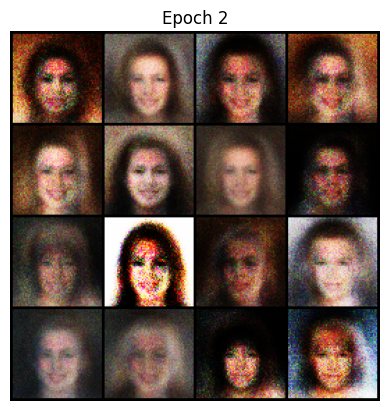

[Epoch 3/20] [Batch 0/1583] [D loss: 0.432233065366745] [G loss: 2.2847084999084473]
[Epoch 3/20] [Batch 50/1583] [D loss: 0.42568081617355347] [G loss: 1.886845588684082]
[Epoch 3/20] [Batch 100/1583] [D loss: 0.3745036721229553] [G loss: 2.184508800506592]
[Epoch 3/20] [Batch 150/1583] [D loss: 0.510981559753418] [G loss: 2.474714994430542]
[Epoch 3/20] [Batch 200/1583] [D loss: 0.46903181076049805] [G loss: 2.2570688724517822]
[Epoch 3/20] [Batch 250/1583] [D loss: 0.35656338930130005] [G loss: 1.9874253273010254]
[Epoch 3/20] [Batch 300/1583] [D loss: 0.3476284146308899] [G loss: 1.9896979331970215]
[Epoch 3/20] [Batch 350/1583] [D loss: 0.44182419776916504] [G loss: 1.5574376583099365]
[Epoch 3/20] [Batch 400/1583] [D loss: 0.4158428907394409] [G loss: 2.3724162578582764]
[Epoch 3/20] [Batch 450/1583] [D loss: 0.46819770336151123] [G loss: 1.941847324371338]
[Epoch 3/20] [Batch 500/1583] [D loss: 0.39545637369155884] [G loss: 2.1441378593444824]
[Epoch 3/20] [Batch 550/1583] [D lo

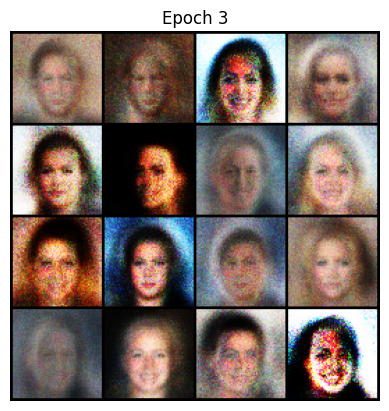

[Epoch 4/20] [Batch 0/1583] [D loss: 0.5937151908874512] [G loss: 1.6432970762252808]
[Epoch 4/20] [Batch 50/1583] [D loss: 0.5162261724472046] [G loss: 2.064724922180176]
[Epoch 4/20] [Batch 100/1583] [D loss: 0.4602161645889282] [G loss: 1.615604281425476]
[Epoch 4/20] [Batch 150/1583] [D loss: 0.40196287631988525] [G loss: 1.7086671590805054]
[Epoch 4/20] [Batch 200/1583] [D loss: 0.5480303764343262] [G loss: 1.7561028003692627]
[Epoch 4/20] [Batch 250/1583] [D loss: 0.42817381024360657] [G loss: 1.6114307641983032]
[Epoch 4/20] [Batch 300/1583] [D loss: 0.41196805238723755] [G loss: 1.524775505065918]
[Epoch 4/20] [Batch 350/1583] [D loss: 0.40218430757522583] [G loss: 2.1487982273101807]
[Epoch 4/20] [Batch 400/1583] [D loss: 0.49458515644073486] [G loss: 1.590641736984253]
[Epoch 4/20] [Batch 450/1583] [D loss: 0.4952426850795746] [G loss: 1.6925612688064575]
[Epoch 4/20] [Batch 500/1583] [D loss: 0.46876928210258484] [G loss: 1.9132097959518433]
[Epoch 4/20] [Batch 550/1583] [D 

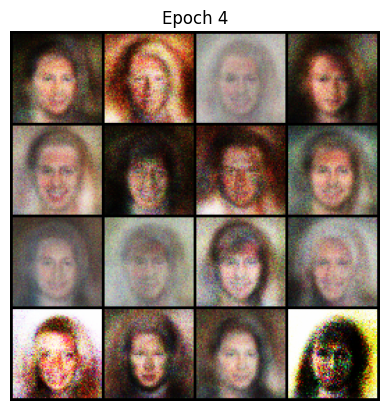

[Epoch 5/20] [Batch 0/1583] [D loss: 0.5108565092086792] [G loss: 2.0028152465820312]
[Epoch 5/20] [Batch 50/1583] [D loss: 0.4803365468978882] [G loss: 2.0630316734313965]
[Epoch 5/20] [Batch 100/1583] [D loss: 0.4766979217529297] [G loss: 1.438600778579712]
[Epoch 5/20] [Batch 150/1583] [D loss: 0.4688478410243988] [G loss: 1.8270344734191895]
[Epoch 5/20] [Batch 200/1583] [D loss: 0.46704667806625366] [G loss: 1.7914961576461792]
[Epoch 5/20] [Batch 250/1583] [D loss: 0.42620936036109924] [G loss: 1.5808336734771729]
[Epoch 5/20] [Batch 300/1583] [D loss: 0.45941266417503357] [G loss: 1.6435953378677368]
[Epoch 5/20] [Batch 350/1583] [D loss: 0.5107307434082031] [G loss: 1.663751482963562]
[Epoch 5/20] [Batch 400/1583] [D loss: 0.48805728554725647] [G loss: 1.3300763368606567]
[Epoch 5/20] [Batch 450/1583] [D loss: 0.5167449712753296] [G loss: 1.882822036743164]
[Epoch 5/20] [Batch 500/1583] [D loss: 0.494510293006897] [G loss: 1.7339978218078613]
[Epoch 5/20] [Batch 550/1583] [D lo

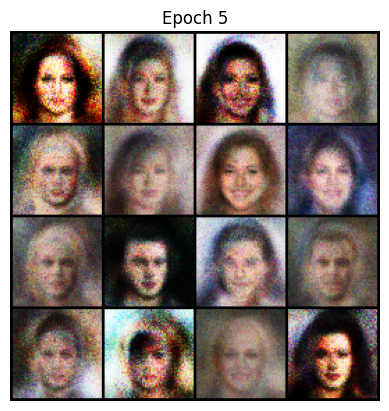

[Epoch 6/20] [Batch 0/1583] [D loss: 0.4983389973640442] [G loss: 1.6023563146591187]
[Epoch 6/20] [Batch 50/1583] [D loss: 0.47369539737701416] [G loss: 1.8495712280273438]
[Epoch 6/20] [Batch 100/1583] [D loss: 0.5226690769195557] [G loss: 1.6344778537750244]
[Epoch 6/20] [Batch 150/1583] [D loss: 0.48243165016174316] [G loss: 1.3980365991592407]
[Epoch 6/20] [Batch 200/1583] [D loss: 0.5342915058135986] [G loss: 1.3523156642913818]
[Epoch 6/20] [Batch 250/1583] [D loss: 0.49781960248947144] [G loss: 1.552058458328247]
[Epoch 6/20] [Batch 300/1583] [D loss: 0.5337033271789551] [G loss: 1.6303520202636719]
[Epoch 6/20] [Batch 350/1583] [D loss: 0.4463990330696106] [G loss: 1.396450161933899]
[Epoch 6/20] [Batch 400/1583] [D loss: 0.5027220845222473] [G loss: 1.6341520547866821]
[Epoch 6/20] [Batch 450/1583] [D loss: 0.4614577293395996] [G loss: 1.5782840251922607]
[Epoch 6/20] [Batch 500/1583] [D loss: 0.5143371820449829] [G loss: 1.5187230110168457]
[Epoch 6/20] [Batch 550/1583] [D l

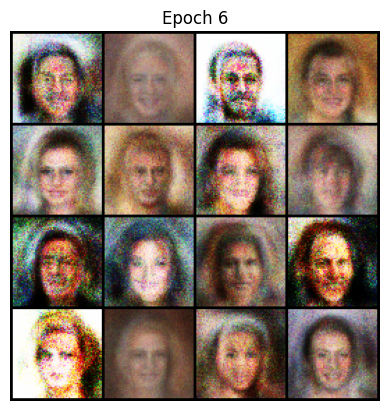

[Epoch 7/20] [Batch 0/1583] [D loss: 0.5680876970291138] [G loss: 1.7681069374084473]
[Epoch 7/20] [Batch 50/1583] [D loss: 0.512377142906189] [G loss: 1.6949442625045776]
[Epoch 7/20] [Batch 100/1583] [D loss: 0.45622342824935913] [G loss: 1.4141077995300293]
[Epoch 7/20] [Batch 150/1583] [D loss: 0.5343166589736938] [G loss: 1.3560606241226196]
[Epoch 7/20] [Batch 200/1583] [D loss: 0.5781609416007996] [G loss: 1.5846012830734253]
[Epoch 7/20] [Batch 250/1583] [D loss: 0.4851193130016327] [G loss: 1.755777359008789]
[Epoch 7/20] [Batch 300/1583] [D loss: 0.4775519371032715] [G loss: 1.4415788650512695]
[Epoch 7/20] [Batch 350/1583] [D loss: 0.4837246537208557] [G loss: 1.4203088283538818]
[Epoch 7/20] [Batch 400/1583] [D loss: 0.5026006102561951] [G loss: 1.6434948444366455]
[Epoch 7/20] [Batch 450/1583] [D loss: 0.4886862635612488] [G loss: 1.4466347694396973]
[Epoch 7/20] [Batch 500/1583] [D loss: 0.46872544288635254] [G loss: 1.4494768381118774]
[Epoch 7/20] [Batch 550/1583] [D lo

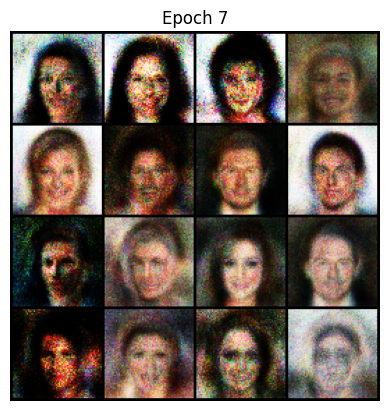

[Epoch 8/20] [Batch 0/1583] [D loss: 0.6093167662620544] [G loss: 1.492661476135254]
[Epoch 8/20] [Batch 50/1583] [D loss: 0.5411123633384705] [G loss: 1.1322672367095947]
[Epoch 8/20] [Batch 100/1583] [D loss: 0.5287668108940125] [G loss: 1.287554383277893]
[Epoch 8/20] [Batch 150/1583] [D loss: 0.5705200433731079] [G loss: 1.222560167312622]
[Epoch 8/20] [Batch 200/1583] [D loss: 0.49605831503868103] [G loss: 1.4198837280273438]
[Epoch 8/20] [Batch 250/1583] [D loss: 0.5413634777069092] [G loss: 1.3219722509384155]
[Epoch 8/20] [Batch 300/1583] [D loss: 0.5673133730888367] [G loss: 1.4199192523956299]
[Epoch 8/20] [Batch 350/1583] [D loss: 0.5339436531066895] [G loss: 1.42026948928833]
[Epoch 8/20] [Batch 400/1583] [D loss: 0.5517846345901489] [G loss: 1.6581459045410156]
[Epoch 8/20] [Batch 450/1583] [D loss: 0.5597867369651794] [G loss: 1.319271206855774]
[Epoch 8/20] [Batch 500/1583] [D loss: 0.5191073417663574] [G loss: 1.2010586261749268]
[Epoch 8/20] [Batch 550/1583] [D loss: 0

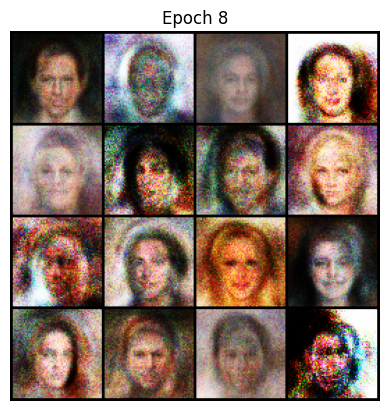

[Epoch 9/20] [Batch 0/1583] [D loss: 0.5957683324813843] [G loss: 1.2942554950714111]
[Epoch 9/20] [Batch 50/1583] [D loss: 0.5613275170326233] [G loss: 1.2546417713165283]
[Epoch 9/20] [Batch 100/1583] [D loss: 0.525786280632019] [G loss: 1.5743341445922852]
[Epoch 9/20] [Batch 150/1583] [D loss: 0.5480482578277588] [G loss: 1.2576621770858765]
[Epoch 9/20] [Batch 200/1583] [D loss: 0.48947015404701233] [G loss: 1.2717781066894531]
[Epoch 9/20] [Batch 250/1583] [D loss: 0.522911548614502] [G loss: 1.3384807109832764]
[Epoch 9/20] [Batch 300/1583] [D loss: 0.5443503856658936] [G loss: 1.2425627708435059]
[Epoch 9/20] [Batch 350/1583] [D loss: 0.5567679405212402] [G loss: 1.1318461894989014]
[Epoch 9/20] [Batch 400/1583] [D loss: 0.5514534711837769] [G loss: 1.413577914237976]
[Epoch 9/20] [Batch 450/1583] [D loss: 0.5495346784591675] [G loss: 1.1842055320739746]
[Epoch 9/20] [Batch 500/1583] [D loss: 0.5745021104812622] [G loss: 1.2888593673706055]
[Epoch 9/20] [Batch 550/1583] [D loss

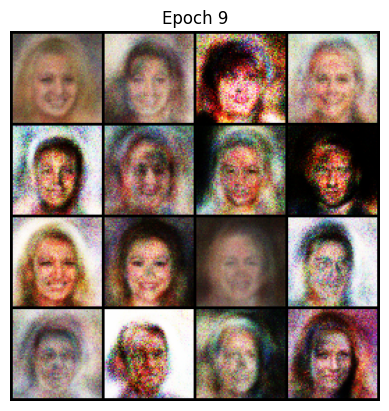

[Epoch 10/20] [Batch 0/1583] [D loss: 0.5737658739089966] [G loss: 1.2618399858474731]
[Epoch 10/20] [Batch 50/1583] [D loss: 0.5651596784591675] [G loss: 1.2957642078399658]
[Epoch 10/20] [Batch 100/1583] [D loss: 0.5081100463867188] [G loss: 1.2945916652679443]
[Epoch 10/20] [Batch 150/1583] [D loss: 0.6070336103439331] [G loss: 1.343355417251587]
[Epoch 10/20] [Batch 200/1583] [D loss: 0.5247756242752075] [G loss: 1.2393138408660889]
[Epoch 10/20] [Batch 250/1583] [D loss: 0.5302159786224365] [G loss: 1.3774175643920898]
[Epoch 10/20] [Batch 300/1583] [D loss: 0.5744569301605225] [G loss: 1.326056957244873]
[Epoch 10/20] [Batch 350/1583] [D loss: 0.5108602046966553] [G loss: 1.2986979484558105]
[Epoch 10/20] [Batch 400/1583] [D loss: 0.5513653755187988] [G loss: 1.321897029876709]
[Epoch 10/20] [Batch 450/1583] [D loss: 0.5745121836662292] [G loss: 1.3589128255844116]
[Epoch 10/20] [Batch 500/1583] [D loss: 0.5282201170921326] [G loss: 1.1719112396240234]
[Epoch 10/20] [Batch 550/15

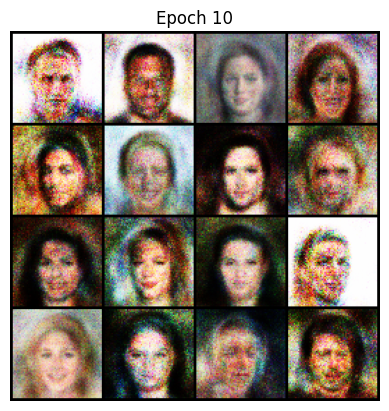

[Epoch 11/20] [Batch 0/1583] [D loss: 0.5259714126586914] [G loss: 1.2860610485076904]
[Epoch 11/20] [Batch 50/1583] [D loss: 0.5728534460067749] [G loss: 0.9582892656326294]
[Epoch 11/20] [Batch 100/1583] [D loss: 0.5542392730712891] [G loss: 1.4447813034057617]
[Epoch 11/20] [Batch 150/1583] [D loss: 0.5513013005256653] [G loss: 1.251640796661377]
[Epoch 11/20] [Batch 200/1583] [D loss: 0.5674213171005249] [G loss: 1.0980355739593506]
[Epoch 11/20] [Batch 250/1583] [D loss: 0.5306493043899536] [G loss: 1.2953041791915894]
[Epoch 11/20] [Batch 300/1583] [D loss: 0.544840395450592] [G loss: 1.367053747177124]
[Epoch 11/20] [Batch 350/1583] [D loss: 0.5593948364257812] [G loss: 1.3462727069854736]
[Epoch 11/20] [Batch 400/1583] [D loss: 0.5692324638366699] [G loss: 1.2117198705673218]
[Epoch 11/20] [Batch 450/1583] [D loss: 0.5632320046424866] [G loss: 1.2840797901153564]
[Epoch 11/20] [Batch 500/1583] [D loss: 0.5745507478713989] [G loss: 1.0630900859832764]
[Epoch 11/20] [Batch 550/15

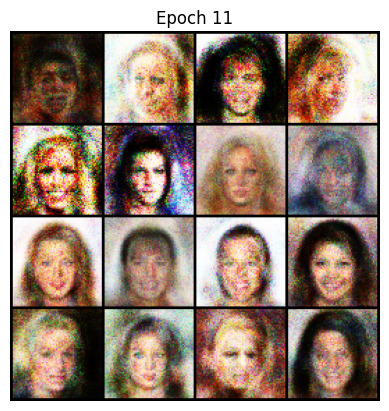

[Epoch 12/20] [Batch 0/1583] [D loss: 0.5830286741256714] [G loss: 1.2354192733764648]
[Epoch 12/20] [Batch 50/1583] [D loss: 0.5686749815940857] [G loss: 1.160651683807373]
[Epoch 12/20] [Batch 100/1583] [D loss: 0.5762083530426025] [G loss: 1.2910311222076416]
[Epoch 12/20] [Batch 150/1583] [D loss: 0.5808649063110352] [G loss: 1.3003829717636108]
[Epoch 12/20] [Batch 200/1583] [D loss: 0.5551867485046387] [G loss: 1.1709973812103271]
[Epoch 12/20] [Batch 250/1583] [D loss: 0.6023092269897461] [G loss: 1.308415174484253]
[Epoch 12/20] [Batch 300/1583] [D loss: 0.5629445910453796] [G loss: 1.36966872215271]
[Epoch 12/20] [Batch 350/1583] [D loss: 0.5872812271118164] [G loss: 1.2308437824249268]
[Epoch 12/20] [Batch 400/1583] [D loss: 0.5673409700393677] [G loss: 1.3748433589935303]
[Epoch 12/20] [Batch 450/1583] [D loss: 0.5203413963317871] [G loss: 1.210625410079956]
[Epoch 12/20] [Batch 500/1583] [D loss: 0.6649720072746277] [G loss: 1.0644981861114502]
[Epoch 12/20] [Batch 550/1583

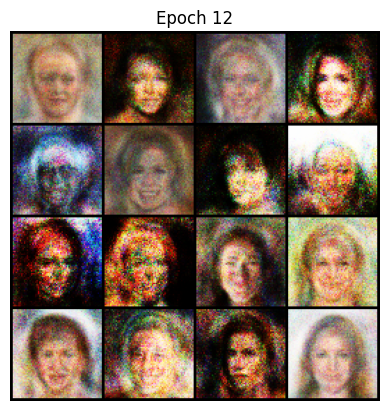

[Epoch 13/20] [Batch 0/1583] [D loss: 0.5881582498550415] [G loss: 1.3229867219924927]
[Epoch 13/20] [Batch 50/1583] [D loss: 0.5172737240791321] [G loss: 0.9627183079719543]
[Epoch 13/20] [Batch 100/1583] [D loss: 0.5239371061325073] [G loss: 1.023430347442627]
[Epoch 13/20] [Batch 150/1583] [D loss: 0.5972649455070496] [G loss: 1.1186953783035278]
[Epoch 13/20] [Batch 200/1583] [D loss: 0.6145525574684143] [G loss: 0.9762539267539978]
[Epoch 13/20] [Batch 250/1583] [D loss: 0.5486618280410767] [G loss: 1.2023125886917114]
[Epoch 13/20] [Batch 300/1583] [D loss: 0.6076014041900635] [G loss: 1.2568585872650146]
[Epoch 13/20] [Batch 350/1583] [D loss: 0.5989078283309937] [G loss: 1.3418636322021484]
[Epoch 13/20] [Batch 400/1583] [D loss: 0.5648577213287354] [G loss: 1.0056382417678833]
[Epoch 13/20] [Batch 450/1583] [D loss: 0.5567922592163086] [G loss: 1.1447668075561523]
[Epoch 13/20] [Batch 500/1583] [D loss: 0.5920040011405945] [G loss: 1.1695506572723389]
[Epoch 13/20] [Batch 550/

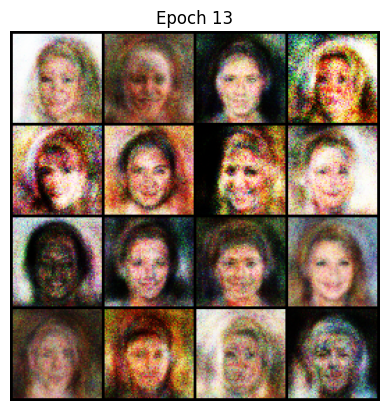

[Epoch 14/20] [Batch 0/1583] [D loss: 0.5052094459533691] [G loss: 1.1631858348846436]
[Epoch 14/20] [Batch 50/1583] [D loss: 0.6810876727104187] [G loss: 1.220085620880127]
[Epoch 14/20] [Batch 100/1583] [D loss: 0.5630865097045898] [G loss: 1.1537106037139893]
[Epoch 14/20] [Batch 150/1583] [D loss: 0.6066811084747314] [G loss: 1.2607498168945312]
[Epoch 14/20] [Batch 200/1583] [D loss: 0.5763418674468994] [G loss: 1.3227673768997192]
[Epoch 14/20] [Batch 250/1583] [D loss: 0.5834755301475525] [G loss: 1.140265703201294]
[Epoch 14/20] [Batch 300/1583] [D loss: 0.5762901306152344] [G loss: 0.9841138124465942]
[Epoch 14/20] [Batch 350/1583] [D loss: 0.5402312278747559] [G loss: 1.1643368005752563]
[Epoch 14/20] [Batch 400/1583] [D loss: 0.5533852577209473] [G loss: 0.9990733861923218]
[Epoch 14/20] [Batch 450/1583] [D loss: 0.5378220677375793] [G loss: 1.1379225254058838]
[Epoch 14/20] [Batch 500/1583] [D loss: 0.5294979810714722] [G loss: 1.08664870262146]
[Epoch 14/20] [Batch 550/158

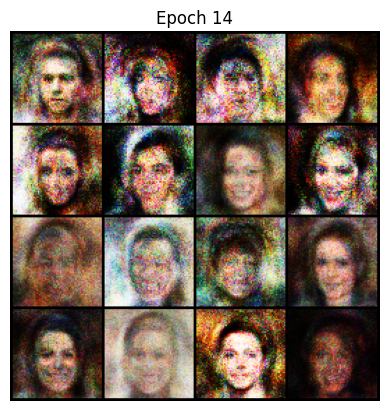

[Epoch 15/20] [Batch 0/1583] [D loss: 0.5462520122528076] [G loss: 1.1987199783325195]
[Epoch 15/20] [Batch 50/1583] [D loss: 0.6133832335472107] [G loss: 1.2388705015182495]
[Epoch 15/20] [Batch 100/1583] [D loss: 0.6052497625350952] [G loss: 1.0649300813674927]
[Epoch 15/20] [Batch 150/1583] [D loss: 0.5754175186157227] [G loss: 1.2215332984924316]
[Epoch 15/20] [Batch 200/1583] [D loss: 0.5560460686683655] [G loss: 1.2398625612258911]
[Epoch 15/20] [Batch 250/1583] [D loss: 0.5323514342308044] [G loss: 1.1670811176300049]
[Epoch 15/20] [Batch 300/1583] [D loss: 0.5444968342781067] [G loss: 1.5123072862625122]
[Epoch 15/20] [Batch 350/1583] [D loss: 0.5239078998565674] [G loss: 1.249206781387329]
[Epoch 15/20] [Batch 400/1583] [D loss: 0.5858747959136963] [G loss: 1.3304201364517212]
[Epoch 15/20] [Batch 450/1583] [D loss: 0.5648024082183838] [G loss: 1.291593074798584]
[Epoch 15/20] [Batch 500/1583] [D loss: 0.605685293674469] [G loss: 1.0877655744552612]
[Epoch 15/20] [Batch 550/15

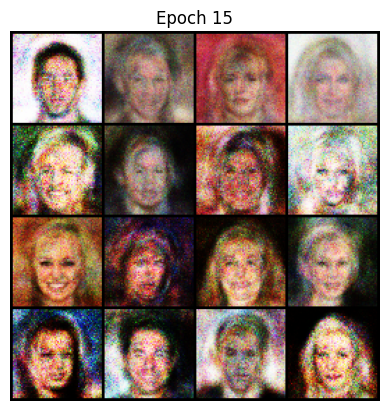

[Epoch 16/20] [Batch 0/1583] [D loss: 0.5286890864372253] [G loss: 1.1237002611160278]
[Epoch 16/20] [Batch 50/1583] [D loss: 0.5216426849365234] [G loss: 1.244338035583496]
[Epoch 16/20] [Batch 100/1583] [D loss: 0.5675644874572754] [G loss: 1.312058925628662]
[Epoch 16/20] [Batch 150/1583] [D loss: 0.577509880065918] [G loss: 1.1805216073989868]
[Epoch 16/20] [Batch 200/1583] [D loss: 0.553667426109314] [G loss: 1.0489811897277832]
[Epoch 16/20] [Batch 250/1583] [D loss: 0.5222554802894592] [G loss: 1.186981439590454]
[Epoch 16/20] [Batch 300/1583] [D loss: 0.5383462905883789] [G loss: 1.1698800325393677]
[Epoch 16/20] [Batch 350/1583] [D loss: 0.5567831993103027] [G loss: 1.1462477445602417]
[Epoch 16/20] [Batch 400/1583] [D loss: 0.55031418800354] [G loss: 1.0162781476974487]
[Epoch 16/20] [Batch 450/1583] [D loss: 0.5458076596260071] [G loss: 1.3498914241790771]
[Epoch 16/20] [Batch 500/1583] [D loss: 0.536899209022522] [G loss: 1.1938636302947998]
[Epoch 16/20] [Batch 550/1583] [

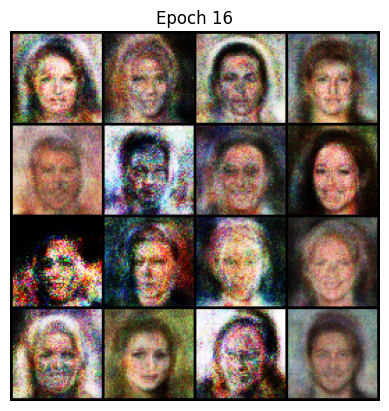

[Epoch 17/20] [Batch 0/1583] [D loss: 0.5108539462089539] [G loss: 1.2996582984924316]
[Epoch 17/20] [Batch 50/1583] [D loss: 0.5437212586402893] [G loss: 1.1253595352172852]
[Epoch 17/20] [Batch 100/1583] [D loss: 0.5361036658287048] [G loss: 1.0305601358413696]
[Epoch 17/20] [Batch 150/1583] [D loss: 0.6011605858802795] [G loss: 1.2807495594024658]
[Epoch 17/20] [Batch 200/1583] [D loss: 0.5558942556381226] [G loss: 1.2960853576660156]
[Epoch 17/20] [Batch 250/1583] [D loss: 0.5794914960861206] [G loss: 1.34280264377594]
[Epoch 17/20] [Batch 300/1583] [D loss: 0.5542371273040771] [G loss: 1.1962311267852783]
[Epoch 17/20] [Batch 350/1583] [D loss: 0.557885468006134] [G loss: 1.1712522506713867]
[Epoch 17/20] [Batch 400/1583] [D loss: 0.5442352294921875] [G loss: 1.2879078388214111]
[Epoch 17/20] [Batch 450/1583] [D loss: 0.5886712074279785] [G loss: 1.0985853672027588]
[Epoch 17/20] [Batch 500/1583] [D loss: 0.5695816278457642] [G loss: 1.2445414066314697]
[Epoch 17/20] [Batch 550/15

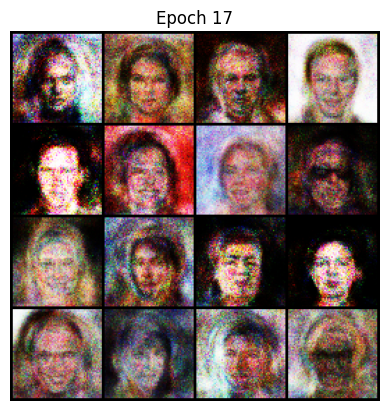

[Epoch 18/20] [Batch 0/1583] [D loss: 0.5577518939971924] [G loss: 1.2503159046173096]
[Epoch 18/20] [Batch 50/1583] [D loss: 0.5097801685333252] [G loss: 1.1604535579681396]
[Epoch 18/20] [Batch 100/1583] [D loss: 0.5867081880569458] [G loss: 1.0058667659759521]
[Epoch 18/20] [Batch 150/1583] [D loss: 0.5935323238372803] [G loss: 1.1456220149993896]
[Epoch 18/20] [Batch 200/1583] [D loss: 0.587888240814209] [G loss: 1.2767722606658936]
[Epoch 18/20] [Batch 250/1583] [D loss: 0.559330940246582] [G loss: 1.2646422386169434]
[Epoch 18/20] [Batch 300/1583] [D loss: 0.5920660495758057] [G loss: 1.3029061555862427]
[Epoch 18/20] [Batch 350/1583] [D loss: 0.5725152492523193] [G loss: 1.1260409355163574]
[Epoch 18/20] [Batch 400/1583] [D loss: 0.5707858204841614] [G loss: 1.1541929244995117]
[Epoch 18/20] [Batch 450/1583] [D loss: 0.5586746335029602] [G loss: 1.2160850763320923]
[Epoch 18/20] [Batch 500/1583] [D loss: 0.5574109554290771] [G loss: 1.1070046424865723]
[Epoch 18/20] [Batch 550/1

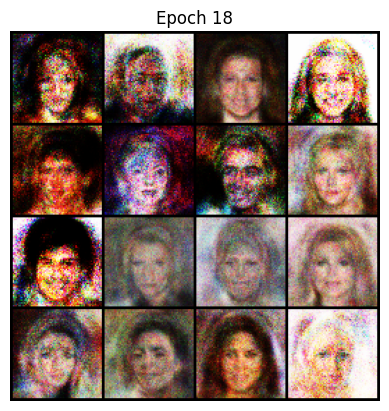

[Epoch 19/20] [Batch 0/1583] [D loss: 0.5621922016143799] [G loss: 1.3499774932861328]
[Epoch 19/20] [Batch 50/1583] [D loss: 0.4870792329311371] [G loss: 1.1434247493743896]
[Epoch 19/20] [Batch 100/1583] [D loss: 0.5560716986656189] [G loss: 1.2927030324935913]
[Epoch 19/20] [Batch 150/1583] [D loss: 0.5644632577896118] [G loss: 1.137096881866455]
[Epoch 19/20] [Batch 200/1583] [D loss: 0.6232718229293823] [G loss: 1.2389603853225708]
[Epoch 19/20] [Batch 250/1583] [D loss: 0.5900717973709106] [G loss: 1.4170960187911987]
[Epoch 19/20] [Batch 300/1583] [D loss: 0.5929296612739563] [G loss: 1.218369483947754]
[Epoch 19/20] [Batch 350/1583] [D loss: 0.5395290851593018] [G loss: 1.2417309284210205]
[Epoch 19/20] [Batch 400/1583] [D loss: 0.5525944828987122] [G loss: 1.0630528926849365]
[Epoch 19/20] [Batch 450/1583] [D loss: 0.5639598965644836] [G loss: 1.2648637294769287]
[Epoch 19/20] [Batch 500/1583] [D loss: 0.6087136268615723] [G loss: 1.2296037673950195]
[Epoch 19/20] [Batch 550/1

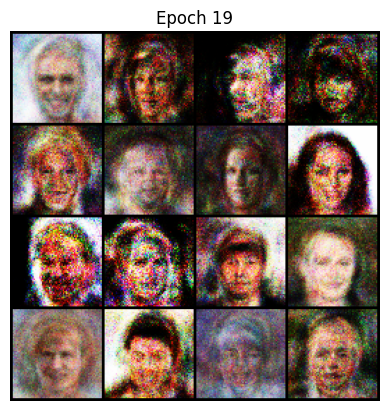

In [13]:

# Start training
train(generator, discriminator, dataloader, epochs=20)

In [1]:
torch.save(generator.state_dict(), "generator.pth")
torch.save(discriminator.state_dict(), "discriminator.pth")


NameError: name 'torch' is not defined